# Import Dependencies


In [1]:
# Import necessary functions from the uploaded files
import os
from final_response_front_end_main import initialize_system, process_query
from final_response_front_end_main import load_query_history
from final_response_front_end_main import flush_prior_qdrant_client_and_initialize_new_client
from user_history_utils import save_chat_pkl_by_embedding
from user_history_utils import save_chat_json

# Setups:

### Below are the various setups of environment variables and functions that are required for **EVERY SESSION**.

## Intialize System Environment (do this once PER BOOT OF SYSTEM)

In [2]:
# Initialize the environment
DEVICE, TOKENIZER, EMBEDDING_MODEL, LLM_MODEL, LLM_SYSTEM_PROMPT, QDRANT_CLIENT, CHUNK_COLLECTION, HISTORY_COLLECTION, BM25_SEARCH_FUNCTION, _, _, _ = initialize_system()

qdrant_vector_store/local_embedding_models/Snowflake/snowflake-arctic-embed-l-v2.0
Loading Snowflake/snowflake-arctic-embed-l-v2.0 from local storage...


Some weights of XLMRobertaModel were not initialized from the model checkpoint at qdrant_vector_store/local_embedding_models/Snowflake/snowflake-arctic-embed-l-v2.0 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Snowflake/snowflake-arctic-embed-l-v2.0 embedding model loaded to cuda


############### System Prompt:

    You are an advanced AI research assistant. Generate detailed and comprehensive responses that supplement students' and academic researchers' work with information grounded in highly cited AI/ML research papers, specifically in fields like NLP and CV. The response should not focus on one area of study but should be informed by both the current query and chat history to generate a well-rounded answer.

    1. **Introductory Overview**: Start with a high-level conceptual overview of the topic, providing a brief and clear explanation that covers the essential aspects of the subject. This should be accessible to a broad audience.

    2. **Technical Overview**: After the conceptual overview, provide a more in-depth, technical explanation that dives deeper into the topic. This could include relevant algorithms, methods, or models, as well as their theoretical foundations.

    3. **Ex

## Initialize a user's chat (do this ONCE PER SESSION / when the next user job is DIFFERENT from the prior user's job)

In [4]:
def initialize_user_chat(
                        task_folder='saved_chats', # The top level folder, where user chats are located
                        user_output_folder='test_user', # The next level folder that stores all of a user's chats (define user names here)
                        saved_chats_topic_name='ey_lmao1', # The bottom level folder that stores a specific chat from the user (contains .json / .pkl files) 
    ):

    directory = f'user_output/{task_folder}/{user_output_folder}/{saved_chats_topic_name}'
    if not os.path.exists(directory):
        os.makedirs(directory)

    # Define the name of the chat, and the .json / .pkl files that will be saved with it
    chat_json_name = f"{saved_chats_topic_name}.json"
    chat_embedded_history_name = 'user_embedded_history.pkl'
    chat_non_embedded_history_name = 'user_non_embedded_history.pkl'

    # Define the path of the json / pkl files
    final_json_path = os.path.join(directory, chat_json_name)
    final_embedded_history_path = os.path.join(directory, chat_embedded_history_name)
    final_non_embedded_history_path = os.path.join(directory, chat_non_embedded_history_name)

    # Load the chat history given these paths
    user_query_state_history, query_num, HISTORICAL_QUERY_NUM = load_query_history(QDRANT_CLIENT=QDRANT_CLIENT, 
            HISTORY_COLLECTION=HISTORY_COLLECTION,
            chat_embedded_history_path=final_embedded_history_path,
            chat_non_embedded_history_path=final_non_embedded_history_path
            )

    initialized_chat_settings = {
        'user_chat_json_path': final_json_path,
        'user_embedded_history_path': final_embedded_history_path,
        'user_non_embedded_history_path': final_non_embedded_history_path,
        'query_num': query_num,
        'historical_query_num': HISTORICAL_QUERY_NUM,
        'user_query_state_history': user_query_state_history
    }

    return initialized_chat_settings


## Call Response Generation Function (DO THIS AS MANY TIMES AS YOU WANT PER SESSION)

In [5]:
def call_back_end_response_generation(
                                      user_query_state_history: dict,
                                      desired_history_window_size: int,
                                      desired_context_chunks_top_k: int,
                                      rag_switch: bool,
                                      history_switch: bool,
                                      bm25_switch: bool,
                                      topic_retrieval_switch: bool,
                                      historic_query_similarity_threshold: float, # [0, 1] range (filter)
                                      query_text: str,
                                      query_num: int,
    ):

    # Call the `process_query()` function with the inputs
    user_query_state_history[query_num] = process_query(
        desired_history_window_size, 
        desired_context_chunks_top_k, 
        rag_switch, 
        history_switch, 
        bm25_switch, 
        topic_retrieval_switch, 
        historic_query_similarity_threshold, 
        query_text, 
        user_query_state_history,
        query_num, 
        QDRANT_CLIENT, 
        CHUNK_COLLECTION,
        HISTORY_COLLECTION,
        LLM_MODEL,
        LLM_SYSTEM_PROMPT,
        DEVICE,
        EMBEDDING_MODEL, 
        TOKENIZER,
        BM25_SEARCH_FUNCTION
    )

    return user_query_state_history[query_num]

## Input a Query to the Backend (DO THIS AS MANY TIMES AS YOU WANT PER SESSION)

In [6]:
def input_query(
                user_chat_settings: dict={}, # the initial settings used to route / initialize the chat  
                frontend_inputs: dict={},
    ):

    MY_USER_JSON_PATH = user_chat_settings['user_chat_json_path']

    query_num = user_chat_settings['query_num']
    #HISTORICAL_QUERY_NUM = user_chat_settings['historical_query_num']
    user_query_state_history = user_chat_settings['user_query_state_history']

    USER_INPUT_QUERY = frontend_inputs['USER_INPUT_QUERY']
    DESIRED_HISTORY_WINDOW_SIZE = frontend_inputs['DESIRED_HISTORY_WINDOW_SIZE']
    DESIRED_CONTEXT_CHUNKS_TOP_K = frontend_inputs['DESIRED_CONTEXT_CHUNKS_TOP_K']
    RAG_SWITCH = frontend_inputs['RAG_SWITCH']
    HISTORY_SWITCH = frontend_inputs['HISTORY_SWITCH']
    BM25_SWITCH = frontend_inputs['BM25_SWITCH']
    TOPIC_RETRIEVAL_SWITCH = frontend_inputs['TOPIC_RETRIEVAL_SWITCH']
    HISTORIC_QUERY_SIMILARITY_THRESHOLD = frontend_inputs['HISTORIC_QUERY_SIMILARITY_THRESHOLD']

    # Increment the query by 1
    query_num += 1

    user_query_state_history[query_num] = call_back_end_response_generation(
                        user_query_state_history=user_query_state_history,
                        desired_history_window_size=DESIRED_HISTORY_WINDOW_SIZE,
                        desired_context_chunks_top_k=DESIRED_CONTEXT_CHUNKS_TOP_K,
                        rag_switch=RAG_SWITCH,
                        history_switch=HISTORY_SWITCH,
                        bm25_switch=BM25_SWITCH,
                        topic_retrieval_switch=TOPIC_RETRIEVAL_SWITCH,
                        historic_query_similarity_threshold=HISTORIC_QUERY_SIMILARITY_THRESHOLD,
                        query_text=USER_INPUT_QUERY,
                        query_num=query_num
    )

    user_chat_settings['user_query_state_history'][query_num] = user_query_state_history[query_num]
    user_chat_settings['query_num'] = query_num

    save_chat_json(user_query_state_history[query_num], file_path=MY_USER_JSON_PATH)
    
    print(f"User State Length: {len(user_query_state_history)}")
    print(f"\nResponse: {user_query_state_history[query_num]['response_text']}\n")

    return user_chat_settings

## Save the Chat Session / Move to next user's job

In [6]:
def end_user_session(user_chat_settings):

    # Save the PKL file at the end of the session
    MY_USER_EMBEDDED_HISTORY_PATH = user_chat_settings['user_embedded_history_path']
    MY_USER_NON_EMBEDDED_HISTORY_PATH = user_chat_settings['user_non_embedded_history_path']
    USER_QUERY_STATE_HISTORY = user_chat_settings['user_query_state_history']

    #flush_qdrant_client(user_id) # to flush the current user's history collection 

    save_chat_pkl_by_embedding(
        user_query_state_history=USER_QUERY_STATE_HISTORY,
        embedded_path=MY_USER_EMBEDDED_HISTORY_PATH,
        non_embedded_path=MY_USER_NON_EMBEDDED_HISTORY_PATH
    )

    flush_prior_qdrant_client_and_initialize_new_client(client=QDRANT_CLIENT, EMBEDDING_MODEL=EMBEDDING_MODEL)

# Initialize For a Single Session:

### Below are steps that need to be taken to initialize and process user inputs in a **single session**, utillizing the functions defined above in the `**Setup**` section.

## Define user's directory to route history

This can handle both new and existing chats, it serves as a method of routing queries to storage spaces as well as routing where to save session information!

All output is stored in the `**user_output**` folder; after that there are 3 levels that you can work with:

1. `user_chat_group`: the folder that indicates the **type** of the chat group
2. `test_user`: the folder that inidcates the actual **user's id / name**
3. `user_chat_topic`: the folder that stores a specific session for a specific user. stores `.pkl` and `.json` files 

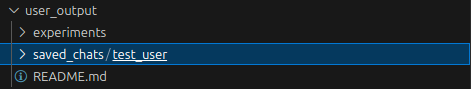

In [12]:
##### Structure of folders:
# user_output/{task_folder}/{user_output_folder}/{saved_chats_topic_name}

user_chat_group = 'saved_chats'
chat_user = 'test_user'
user_chat_topic = 'ey_lmao25'

initial_user_chat_settings = initialize_user_chat(
    task_folder=user_chat_group,
    user_output_folder=chat_user,
    saved_chats_topic_name=user_chat_topic, 
)

Loading chat, start from query number: 7



## Input Queries during the Session:

Now that we have defined our environment, and our session routing information, we can being inputting queries.

In [13]:
#######################################
#### First Query
#######################################

my_front_end_settings_query_1 = {
    'USER_INPUT_QUERY' : 'hello, how are you today?',
    'DESIRED_HISTORY_WINDOW_SIZE' : 3,
    'DESIRED_CONTEXT_CHUNKS_TOP_K' : 5,
    'RAG_SWITCH' : True,
    'HISTORY_SWITCH' : True,
    'BM25_SWITCH' : True,
    'TOPIC_RETRIEVAL_SWITCH' : True,
    'HISTORIC_QUERY_SIMILARITY_THRESHOLD' : 0.3,
}

# Call for each query
user_chat_settings = input_query(
    user_chat_settings=initial_user_chat_settings, 
    frontend_inputs=my_front_end_settings_query_1,
)

#### Chunk ID: 6661, Title: Llama 2: Open Foundation and Fine-Tuned Chat Models, Publish Date: 2023-07 , Link: https://arxiv.org/abs/2307.09288, # of Tokens: 354, Section: **Llama 2: Open Foundation and Fine-Tuned Chat Models** ---> **A Appendix**
#### Chunk ID: 2261, Title: Llama 2: Open Foundation and Fine-Tuned Chat Models, Publish Date: 2023-07 , Link: https://arxiv.org/abs/2307.09288, # of Tokens: 657, Section: **Llama 2: Open Foundation and Fine-Tuned Chat Models** ---> **A Appendix**
#### Chunk ID: 4087, Title: Llama 2: Open Foundation and Fine-Tuned Chat Models, Publish Date: 2023-07 , Link: https://arxiv.org/abs/2307.09288, # of Tokens: 637, Section: **Llama 2: Open Foundation and Fine-Tuned Chat Models** ---> **A Appendix**
#### Chunk ID: 2264, Title: Llama 2: Open Foundation and Fine-Tuned Chat Models, Publish Date: 2023-07 , Link: https://arxiv.org/abs/2307.09288, # of Tokens: 672, Section: **Llama 2: Open Foundation and Fine-Tuned Chat Models** ---> **A Appendix**
#### Chu

In [14]:
collection_info = QDRANT_CLIENT.get_collection("history_collection")

print(collection_info)

status=<CollectionStatus.GREEN: 'green'> optimizer_status=<OptimizersStatusOneOf.OK: 'ok'> vectors_count=None indexed_vectors_count=0 points_count=8 segments_count=1 config=CollectionConfig(params=CollectionParams(vectors=VectorParams(size=1024, distance=<Distance.COSINE: 'Cosine'>, hnsw_config=None, quantization_config=None, on_disk=None, datatype=None, multivector_config=None), shard_number=None, sharding_method=None, replication_factor=None, write_consistency_factor=None, read_fan_out_factor=None, on_disk_payload=None, sparse_vectors=None), hnsw_config=HnswConfig(m=16, ef_construct=100, full_scan_threshold=10000, max_indexing_threads=0, on_disk=None, payload_m=None), optimizer_config=OptimizersConfig(deleted_threshold=0.2, vacuum_min_vector_number=1000, default_segment_number=0, max_segment_size=None, memmap_threshold=None, indexing_threshold=20000, flush_interval_sec=5, max_optimization_threads=1), wal_config=WalConfig(wal_capacity_mb=32, wal_segments_ahead=0), quantization_config=

In [15]:
end_user_session(user_chat_settings)

Collection "history_collection" has been deleted; new collection "history_collection" has been instantiated.


In [16]:
QDRANT_CLIENT

In [17]:
collection_info = QDRANT_CLIENT.get_collection("history_collection")

print(collection_info)

status=<CollectionStatus.GREEN: 'green'> optimizer_status=<OptimizersStatusOneOf.OK: 'ok'> vectors_count=None indexed_vectors_count=0 points_count=0 segments_count=1 config=CollectionConfig(params=CollectionParams(vectors=VectorParams(size=1024, distance=<Distance.COSINE: 'Cosine'>, hnsw_config=None, quantization_config=None, on_disk=None, datatype=None, multivector_config=None), shard_number=None, sharding_method=None, replication_factor=None, write_consistency_factor=None, read_fan_out_factor=None, on_disk_payload=None, sparse_vectors=None), hnsw_config=HnswConfig(m=16, ef_construct=100, full_scan_threshold=10000, max_indexing_threads=0, on_disk=None, payload_m=None), optimizer_config=OptimizersConfig(deleted_threshold=0.2, vacuum_min_vector_number=1000, default_segment_number=0, max_segment_size=None, memmap_threshold=None, indexing_threshold=20000, flush_interval_sec=5, max_optimization_threads=1), wal_config=WalConfig(wal_capacity_mb=32, wal_segments_ahead=0), quantization_config=

In [10]:
my_front_end_settings_query_1 = {
    'USER_INPUT_QUERY' : 'hello, how are you today?',
    'DESIRED_HISTORY_WINDOW_SIZE' : 3,
    'DESIRED_CONTEXT_CHUNKS_TOP_K' : 5,
    'RAG_SWITCH' : True,
    'HISTORY_SWITCH' : True,
    'BM25_SWITCH' : True,
    'TOPIC_RETRIEVAL_SWITCH' : False,
    'HISTORIC_QUERY_SIMILARITY_THRESHOLD' : 0.3,
}

# Call for each query
user_chat_settings = input_query(
    user_chat_settings=initial_user_chat_settings, 
    frontend_inputs=my_front_end_settings_query_1,
)

#### Chunk ID: 6661, Title: Training language models to follow instructions with human feedback, Publish Date: 2022-03 , Link: https://arxiv.org/abs/2203.02155, # of Tokens: 594, Section: **Training language models to follow instructions** **with human feedback** ---> **A Additional prompt data details**
#### Chunk ID: 2261, Title: A Neural Conversational Model, Publish Date: 2015-06 , Link: https://arxiv.org/abs/1506.05869, # of Tokens: 503, Section: **A Neural Conversational Model** ---> **5. Experiments**
#### Chunk ID: 4087, Title: Training language models to follow instructions with human feedback, Publish Date: 2022-03 , Link: https://arxiv.org/abs/2203.02155, # of Tokens: 607, Section: **Training language models to follow instructions** **with human feedback** ---> **A Additional prompt data details**
#### Chunk ID: 2264, Title: A Neural Conversational Model, Publish Date: 2015-06 , Link: https://arxiv.org/abs/1506.05869, # of Tokens: 597, Section: **A Neural Conversational Mode

In [11]:
##### Structure of folders:
# user_output/{task_folder}/{user_output_folder}/{saved_chats_topic_name}

user_chat_group = 'saved_chats'
chat_user = 'test_user2'
user_chat_topic = 'ey_lmao2'

initial_user_chat_settings = initialize_user_chat(
    task_folder=user_chat_group,
    user_output_folder=chat_user,
    saved_chats_topic_name=user_chat_topic, 
)

Loading chat, start from query number: 0



In [12]:
#######################################
#### First Query
#######################################

my_front_end_settings_query_1 = {
    'USER_INPUT_QUERY' : 'hello, how are you today?',
    'DESIRED_HISTORY_WINDOW_SIZE' : 3,
    'DESIRED_CONTEXT_CHUNKS_TOP_K' : 5,
    'RAG_SWITCH' : True,
    'HISTORY_SWITCH' : True,
    'BM25_SWITCH' : True,
    'TOPIC_RETRIEVAL_SWITCH' : True,
    'HISTORIC_QUERY_SIMILARITY_THRESHOLD' : 0.3,
}

# Call for each query
user_chat_settings = input_query(
    user_chat_settings=initial_user_chat_settings, 
    frontend_inputs=my_front_end_settings_query_1,
)

History was meant to be utilized, but the window_size is 0, so no lookback will be performed (window size == 0, no history requested).
#### Chunk ID: 6661, Title: Llama 2: Open Foundation and Fine-Tuned Chat Models, Publish Date: 2023-07 , Link: https://arxiv.org/abs/2307.09288, # of Tokens: 354, Section: **Llama 2: Open Foundation and Fine-Tuned Chat Models** ---> **A Appendix**
#### Chunk ID: 2261, Title: Llama 2: Open Foundation and Fine-Tuned Chat Models, Publish Date: 2023-07 , Link: https://arxiv.org/abs/2307.09288, # of Tokens: 657, Section: **Llama 2: Open Foundation and Fine-Tuned Chat Models** ---> **A Appendix**
#### Chunk ID: 4087, Title: Llama 2: Open Foundation and Fine-Tuned Chat Models, Publish Date: 2023-07 , Link: https://arxiv.org/abs/2307.09288, # of Tokens: 637, Section: **Llama 2: Open Foundation and Fine-Tuned Chat Models** ---> **A Appendix**
#### Chunk ID: 2264, Title: Llama 2: Open Foundation and Fine-Tuned Chat Models, Publish Date: 2023-07 , Link: https://ar

In [13]:
##### Structure of folders:
# user_output/{task_folder}/{user_output_folder}/{saved_chats_topic_name}

user_chat_group = 'saved_chats'
chat_user = 'test_user'
user_chat_topic = 'ey_lmao2'

initial_user_chat_settings = initialize_user_chat(
    task_folder=user_chat_group,
    user_output_folder=chat_user,
    saved_chats_topic_name=user_chat_topic, 
)

Loading chat, start from query number: 18



In [15]:
##### Structure of folders:
# user_output/{task_folder}/{user_output_folder}/{saved_chats_topic_name}

user_chat_group = 'saved_chats'
chat_user = 'test_user2'
user_chat_topic = 'ey_lmao2'

initial_user_chat_settings = initialize_user_chat(
    task_folder=user_chat_group,
    user_output_folder=chat_user,
    saved_chats_topic_name=user_chat_topic, 
)

Loading chat, start from query number: 0



In [14]:
user_chat_settings

{'user_chat_json_path': 'user_output/saved_chats/test_user2/ey_lmao2/ey_lmao2.json',
 'user_embedded_history_path': 'user_output/saved_chats/test_user2/ey_lmao2/user_embedded_history.pkl',
 'user_non_embedded_history_path': 'user_output/saved_chats/test_user2/ey_lmao2/user_non_embedded_history.pkl',
 'query_num': 1,
 'historical_query_num': 0,
 'user_query_state_history': {1: {'query_number': 1,
   'query_text': 'hello, how are you today?',
   'query_embedding': [-0.033832915127277374,
    0.008098253980278969,
    -0.03232055902481079,
    -0.056461550295352936,
    -0.028975700959563255,
    0.004647496622055769,
    0.0447278693318367,
    0.039499253034591675,
    -0.01821332797408104,
    -0.036969419568777084,
    -0.005970797501504421,
    0.02120761200785637,
    0.03863900899887085,
    -0.00940358079969883,
    0.009253262542188168,
    0.07733768969774246,
    -0.02736302837729454,
    -0.0032472817692905664,
    -0.05290427431464195,
    -0.04829259589314461,
    -0.0762454

In [ ]:
#######################################
#### First Query
#######################################

my_front_end_settings_query_1 = {
    'USER_INPUT_QUERY' : 'hello, how are you today?',
    'DESIRED_HISTORY_WINDOW_SIZE' : 3,
    'DESIRED_CONTEXT_CHUNKS_TOP_K' : 5,
    'RAG_SWITCH' : True,
    'HISTORY_SWITCH' : True,
    'BM25_SWITCH' : True,
    'TOPIC_RETRIEVAL_SWITCH' : False,
    'HISTORIC_QUERY_SIMILARITY_THRESHOLD' : 0.3,
}


In [ ]:
#######################################
#### First Query
#######################################

my_front_end_settings_query_1 = {
    'USER_INPUT_QUERY' : 'hello, how are you today?',
    'DESIRED_HISTORY_WINDOW_SIZE' : 3,
    'DESIRED_CONTEXT_CHUNKS_TOP_K' : 5,
    'RAG_SWITCH' : True,
    'HISTORY_SWITCH' : True,
    'BM25_SWITCH' : True,
    'TOPIC_RETRIEVAL_SWITCH' : True,
    'HISTORIC_QUERY_SIMILARITY_THRESHOLD' : 0.3,
}

# Call for each query
user_chat_settings = input_query(
    user_chat_settings=initial_user_chat_settings, 
    frontend_inputs=my_front_end_settings_query_1,
)

#######################################
#### Second Query
#######################################

my_front_end_settings_query_2 = {
    'USER_INPUT_QUERY' : 'is the sky blue?',
    'DESIRED_HISTORY_WINDOW_SIZE' : 3,
    'DESIRED_CONTEXT_CHUNKS_TOP_K' : 5,
    'RAG_SWITCH' : True,
    'HISTORY_SWITCH' : True,
    'BM25_SWITCH' : True,
    'TOPIC_RETRIEVAL_SWITCH' : True,
    'HISTORIC_QUERY_SIMILARITY_THRESHOLD' : 0.3,
}

# Call for each query
user_chat_settings = input_query(
    user_chat_settings=user_chat_settings, 
    frontend_inputs=my_front_end_settings_query_2,
)

#######################################
#### Final Query
#######################################

my_front_end_settings_query_3 = {
    'USER_INPUT_QUERY' : 'what does the ocean sound like?',
    'DESIRED_HISTORY_WINDOW_SIZE' : 3,
    'DESIRED_CONTEXT_CHUNKS_TOP_K' : 5,
    'RAG_SWITCH' : True,
    'HISTORY_SWITCH' : True,
    'BM25_SWITCH' : True,
    'TOPIC_RETRIEVAL_SWITCH' : True,
    'HISTORIC_QUERY_SIMILARITY_THRESHOLD' : 0.3,
}

# When the user decides to end the session (e.g., after the last query)
user_chat_settings = input_query(
    user_chat_settings=user_chat_settings, 
    frontend_inputs=my_front_end_settings_query_3, 
)

# End the current user's session and save their history permanently
end_user_session(user_chat_settings=user_chat_settings)

#### Chunk ID: 6661, Title: Llama 2: Open Foundation and Fine-Tuned Chat Models, Publish Date: 2023-07 , Link: https://arxiv.org/abs/2307.09288, # of Tokens: 354, Section: **Llama 2: Open Foundation and Fine-Tuned Chat Models** ---> **A Appendix**
#### Chunk ID: 2261, Title: Llama 2: Open Foundation and Fine-Tuned Chat Models, Publish Date: 2023-07 , Link: https://arxiv.org/abs/2307.09288, # of Tokens: 657, Section: **Llama 2: Open Foundation and Fine-Tuned Chat Models** ---> **A Appendix**
#### Chunk ID: 4087, Title: Llama 2: Open Foundation and Fine-Tuned Chat Models, Publish Date: 2023-07 , Link: https://arxiv.org/abs/2307.09288, # of Tokens: 637, Section: **Llama 2: Open Foundation and Fine-Tuned Chat Models** ---> **A Appendix**
#### Chunk ID: 2264, Title: Llama 2: Open Foundation and Fine-Tuned Chat Models, Publish Date: 2023-07 , Link: https://arxiv.org/abs/2307.09288, # of Tokens: 672, Section: **Llama 2: Open Foundation and Fine-Tuned Chat Models** ---> **A Appendix**
#### Chu

In [11]:
user_chat_settings['user_query_state_history'].keys()

dict_keys([1, 2, 3, 4, 5, 6])

In [10]:
user_chat_settings['user_query_state_history'][1].keys()

dict_keys(['query_number', 'query_text', 'query_embedding', 'rag_used', 'history_used', 'rag_and_history_used', 'bm25_used', 'topic_retrieval_used', 'desired_lookback_window_size', 'actual_lookback_window_size', 'desired_top_k_chunks', 'query_start_time', 'query_finish_time', 'query_processing_time', 'context_ids_utilized', 'context_ids_source', 'response_text', 'prompt_token_count', 'candidates_token_count', 'total_token_count', 'system_prompt_used', 'dynamic_prompt_body', 'current_state_context_ids', 'current_state_context_scores', 'retrieval_top_k', 'retrieval_method', 'avg_similarity_to_context', 'max_similarity_to_context', 'top_context_id', 'top_context_score', 'considered_prior_state_ids', 'utilized_prior_state_ids', 'filter_similarity_score_threshold', 'filter_similarity_score_mask', 'bm25_RRF_constant', 'bm25_multiplier', 'current_state_bm25_context_ids', 'current_state_bm25_context_scores', 'current_state_hybrid_fused_scores', 'top_topic_chunk_ids', 'top_topic_chunk_similarit

In [13]:
most_recent_chat_query_num = list(user_chat_settings['user_query_state_history'].keys())[-1]

In [14]:
user_chat_settings['user_query_state_history'][most_recent_chat_query_num]['response_text']

'Let\'s delve into the question, "What does the ocean sound like?"\n\n### 1. Introductory Overview\n\nThe query "What does the ocean sound like?" is a fascinating example of a task for an AI model. It goes beyond simple factual recall, demanding the model to generate a description of a sensory experience. The model must leverage its knowledge of the ocean and its associated sounds, and then translate this into a descriptive, easily understandable narrative.\n\n### 2. Technical Overview\n\nTo address this question, an AI model would need to combine several capabilities:\n\n*   **Knowledge Retrieval:** The model must access its learned information about the ocean. This knowledge is typically embedded within its parameters, acquired through training on vast text and, potentially, audio datasets.\n*   **Auditory Sensory Understanding:** The model needs to associate the concept of "ocean" with characteristic sounds.\n*   **Descriptive Language Generation:** It has to generate text that desc

# IMPORTANT - A Potential Guide to Handling Multiple Users / Scheduling

If you want to swap to process different user queries; you will have to re-route before each input query. This means that if you want to serve multiple users, you have to save to set `**end_session=True**` for every job from every user, otherwise the qdrant store that handles searches against user queries will be populated by everybody's history at the same time. Furthermore, it will over-write itself because the query_ids that it utilizes (values such as `1`, `2`, `3`) will be overwritten by multiple users using the system at the same time.

Handling this by creating a seperate collection for each user is not the worst solution at our scale, but making this dynamic would be a massive pain.

## Scheduling Guide

In order to handle multiple users; you process the first input query, and then hold their routing information / information until the next input query. If the next input query's source is different, we can load the new routing information and process their query. If the next input query's source is the same, we can simply process the query without having to re-load their information.

### Variable Definitions:

Each user has query routing information based on their UUID / their connection information:

```python
##### Structure of folders:
# user_output/{task_folder}/{user_output_folder}/{saved_chats_topic_name}

user_chat_group: str = 'saved_chats' # this stores all user chats
chat_user: str = 'test_user2' # this stores a specific user's multiple chat
user_chat_topic: str = 'my_chat' # this is a specific user's single chat

# path would be = 'user_output/saved_chats/test_user2/my_chat'

initial_user_chat_settings = initialize_user_chat(
    task_folder=user_chat_group,
    user_output_folder=chat_user,
    saved_chats_topic_name=user_chat_topic, 
)
```

<br>

Each Job has information structured:

```python
job = {
    'USER_INPUT_QUERY' : str,
    'DESIRED_HISTORY_WINDOW_SIZE' : int,
    'DESIRED_CONTEXT_CHUNKS_TOP_K' : int,
    'RAG_SWITCH' : bool,
    'HISTORY_SWITCH' : bool,
    'BM25_SWITCH' : bool,
    'TOPIC_RETRIEVAL_SWITCH' : bool,
    'HISTORIC_QUERY_SIMILARITY_THRESHOLD' : float,
}
```

<br>

Say we have 2 users:

our_unique_users = [`user_1`, `user_2`]

<br>

And they input jobs that can be sequentially ordered:

`user_1`: `job_1`, `job_2`, `job_4`

`user_2`: `job_3`, `job_5`

<br>

Where a schedule is represented like this:

all_jobs_t0 =        [ `job_1`,  `job_2`,  `job_3`,  `job_4`, `job_5`]
all_jobs_source_t0 = [`user_1`, `user_1`, `user_2`, `user_1`,`user_2`]

Where `t0` refers to the time step.

<br>

### Scheudling Example Code:

#### Time step t=0:

We start with `user_1` who has `job_1`. We have to load their routing information and process their job so that we can serve them with their response.

``` python
#######################################
#### First Query: `job_1` from `user_1`
#######################################

# Now we initialize `user_1` chat using their routing information
user_chat_group = 'saved_chats'
chat_user = 'user_1'
user_chat_topic = 'user_1_chat'

initial_user_chat_settings = initialize_user_chat(
    task_folder=user_chat_group,
    user_output_folder=chat_user,
    saved_chats_topic_name=user_chat_topic, 
)

job_1 = {
    'USER_INPUT_QUERY' : 'hello, how are you today?',
    'DESIRED_HISTORY_WINDOW_SIZE' : 3,
    'DESIRED_CONTEXT_CHUNKS_TOP_K' : 5,
    'RAG_SWITCH' : True,
    'HISTORY_SWITCH' : True,
    'BM25_SWITCH' : True,
    'TOPIC_RETRIEVAL_SWITCH' : True,
    'HISTORIC_QUERY_SIMILARITY_THRESHOLD' : 0.3,
}

# Call for each query
user_chat_settings = input_query(
    user_chat_settings=initial_user_chat_settings, 
    frontend_inputs=job_1,
)
```

#### Time step t=1:

Updated queue at time step 1:

all_jobs_t1 =        [ `job_2`,  `job_3`,  `job_4`, `job_5`]
all_jobs_source_t1 = [`user_1`, `user_2`, `user_1`,`user_2`]

Nobody else inputs a query before `user_1` inputs `job_2`, so their data does not have to be permanently saved and reloaded in order to process `job_2`. 

```python
#######################################
#### Second Query `job_2` from `user_1`
#######################################

job_2 = {
    'USER_INPUT_QUERY' : 'is the sky blue?',
    'DESIRED_HISTORY_WINDOW_SIZE' : 3,
    'DESIRED_CONTEXT_CHUNKS_TOP_K' : 5,
    'RAG_SWITCH' : True,
    'HISTORY_SWITCH' : True,
    'BM25_SWITCH' : True,
    'TOPIC_RETRIEVAL_SWITCH' : True,
    'HISTORIC_QUERY_SIMILARITY_THRESHOLD' : 0.3,
}

# Call for each query
user_chat_settings = input_query(
    user_chat_settings=user_chat_settings, 
    frontend_inputs=job_2,
)
```

#### Time step t=2:

Updated queue at time step 2:

all_jobs_t2 =        [ `job_3`,  `job_4`, `job_5`]
all_jobs_source_t2 = [`user_2`, `user_1`,`user_2`]

Now, `user_2` is the owner of the next job, `job_3`. However, we are still holding `user_1` routing information; we have to end their session and permanently save their session information. After this, we can get `user_2` routing information in to process `job_3`.

```python
# End `user_1` session and save their history permanently
end_user_session(user_chat_settings=user_chat_settings)

#######################################
#### Third Query `job_3` from `user_2`
#######################################

# Now we initialize `user_2` chat using their routing information
user_chat_group = 'saved_chats'
chat_user = 'user_2'
user_chat_topic = 'user_2_chat'

initial_user_chat_settings = initialize_user_chat(
    task_folder=user_chat_group,
    user_output_folder=chat_user,
    saved_chats_topic_name=user_chat_topic, 
)

job_3 = {
    'USER_INPUT_QUERY' : 'what does the ocean sound like?',
    'DESIRED_HISTORY_WINDOW_SIZE' : 3,
    'DESIRED_CONTEXT_CHUNKS_TOP_K' : 5,
    'RAG_SWITCH' : True,
    'HISTORY_SWITCH' : True,
    'BM25_SWITCH' : True,
    'TOPIC_RETRIEVAL_SWITCH' : True,
    'HISTORIC_QUERY_SIMILARITY_THRESHOLD' : 0.3,
}

# When the user decides to end the session (e.g., after the last query)
user_chat_settings = input_query(
    user_chat_settings=user_chat_settings, 
    frontend_inputs=job_3, 
)
```

#### Time step t=3:

Updated queue at time step 3:

all_jobs_t3 =        [ `job_4`, `job_5`]
all_jobs_source_t3 = [`user_1`,`user_2`]

Now, `user_1` has `job_4`. We need to end `user_2` session and save their information to process `job_4`.

```python
# End `user_2` session and save their history permanently
end_user_session(user_chat_settings=user_chat_settings)

#######################################
#### Fourth Query `job_4` from `user_1`
#######################################

# Now we initialize `user_1` chat using their routing information
user_chat_group = 'saved_chats'
chat_user = 'user_1'
user_chat_topic = 'user_1_chat'

initial_user_chat_settings = initialize_user_chat(
    task_folder=user_chat_group,
    user_output_folder=chat_user,
    saved_chats_topic_name=user_chat_topic, 
)

job_4 = {
    'USER_INPUT_QUERY' : 'hello, how are you today?',
    'DESIRED_HISTORY_WINDOW_SIZE' : 3,
    'DESIRED_CONTEXT_CHUNKS_TOP_K' : 5,
    'RAG_SWITCH' : True,
    'HISTORY_SWITCH' : True,
    'BM25_SWITCH' : True,
    'TOPIC_RETRIEVAL_SWITCH' : True,
    'HISTORIC_QUERY_SIMILARITY_THRESHOLD' : 0.3,
}

# Call for each query
user_chat_settings = input_query(
    user_chat_settings=initial_user_chat_settings, 
    frontend_inputs=job_4,
)
```

#### Time step t=4:

Updated queue at time step 4:

all_jobs_t4 =        [ `job_5`]
all_jobs_source_t4 = [`user_2`]

Finally, `user_2` inputs `job_5`. We permanently save `user_1` information and route to `user_2`.

```python
# End `user_1` session and save their history permanently
end_user_session(user_chat_settings=user_chat_settings)

#######################################
#### Fifth Query `job_5` from `user_2`
#######################################

# Now we initialize `user_2` chat using their routing information
user_chat_group = 'saved_chats'
chat_user = 'user_2'
user_chat_topic = 'user_2_chat'

initial_user_chat_settings = initialize_user_chat(
    task_folder=user_chat_group,
    user_output_folder=chat_user,
    saved_chats_topic_name=user_chat_topic, 
)

job_5 = {
    'USER_INPUT_QUERY' : 'hello, how are you today?',
    'DESIRED_HISTORY_WINDOW_SIZE' : 3,
    'DESIRED_CONTEXT_CHUNKS_TOP_K' : 5,
    'RAG_SWITCH' : True,
    'HISTORY_SWITCH' : True,
    'BM25_SWITCH' : True,
    'TOPIC_RETRIEVAL_SWITCH' : True,
    'HISTORIC_QUERY_SIMILARITY_THRESHOLD' : 0.3,
}

# Call for each query
user_chat_settings = input_query(
    user_chat_settings=initial_user_chat_settings, 
    frontend_inputs=job_5,
)
```

#### Conclusion:

Lastly, we hold of on saving permanent history until the next job enters our queue. If the user who we just served (in this case, `user_2`) decides to close out of the application or start a new chat, trigger a permanent save of their last chat and keep waiting for the next job. 

And now we have completed all the scheduled jobs, while maintaining a permanent session history!